In [9]:
import pandas as pd
df = pd.read_csv(r'C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Volga.csv')
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,node_158,node_159,"Udmurts,Besermyan","Udmurts,Besermyan",44.22830,5,11.81180
1,node_158,node_160,"Udmurts,Besermyan","Udmurts,Besermyan",32.09880,4,11.42640
2,node_158,node_161,"Udmurts,Besermyan","Udmurts,Besermyan",51.91020,6,10.48110
3,node_158,node_162,"Udmurts,Besermyan","Udmurts,Besermyan",35.44570,3,13.15160
4,node_158,node_163,"Udmurts,Besermyan","Udmurts,Besermyan",24.03060,2,16.08090
...,...,...,...,...,...,...,...
169374,node_16079,node_16098,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",Chuvash,10.51550,1,10.51550
169375,node_16079,node_16100,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",27.97480,2,21.79260
169376,node_16082,node_16086,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",28.95360,2,18.24450
169377,node_16086,node_16089,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens","Tatars,Volga-Tatars,Mishar-Tatars,Kryashens",8.47385,1,8.47385


In [11]:
df[['node_id1', 'node_id2']].to_csv('volga.edges', index=None, header=None)

# Libs

In [1]:
import pandas as pd
import importlib
import genlink
import torch
import numpy as np
import random
importlib.reload(genlink)
from genlink import DataProcessor, NullSimulator, Trainer, TAGConv_3l_128h_w_k3, TAGConv_3l_512h_w_k3

In [34]:
from torch.nn import Conv2d

layer = Conv2d(1, 1, 2, stride=2, padding=1, dilation=2, bias=False)
layer.weight.data = torch.tensor([[[[2., 1.], [-1., -2.]]]])
print(layer.weight)

data = torch.tensor([[1, 0, -4, 2], [5, 2, 3, 0], [-1, 0, 1, 4], [0, -3, 2, -1]]).float()
print(data)
print(layer(data[None, None, :, :]))

Parameter containing:
tensor([[[[ 2.,  1.],
          [-1., -2.]]]], requires_grad=True)
tensor([[ 1.,  0., -4.,  2.],
        [ 5.,  2.,  3.,  0.],
        [-1.,  0.,  1.,  4.],
        [ 0., -3.,  2., -1.]])
tensor([[[[-4., -2.],
          [ 8.,  9.]]]], grad_fn=<ConvolutionBackward0>)


In [28]:
np.array([[1., 0.], [5., 2.]]) @ np.array([[2., 1.], [-1., -2.]])

array([[2., 1.],
       [8., 1.]])

# Null simulations

Make train samples:   0%|                                                                      | 0/362 [00:00<?, ?it/s]

n_pops=2
(2, 2, 300, 300)


Compute metrics:  22%|█████████████▋                                                 | 26/120 [00:00<00:00, 255.46it/s]


Training for data: nc_null_sim_100


Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 258.00it/s]

Training samples:   3%|█▏                                       | 11/362 [00:00<00:03, 106.03it/s, val_best_score=0.13]

Evaluation report
              precision    recall  f1-score   support

           0       0.23      0.30      0.26        60
           1       0.00      0.00      0.00        60

    accuracy                           0.15       120
   macro avg       0.12      0.15      0.13       120
weighted avg       0.12      0.15      0.13       120

f1 macro improvement to 0.13043478260869565



Training samples: 100%|████████████████████████████████████████| 362/362 [00:03<00:00, 110.49it/s, val_best_score=0.13]

Compute metrics:  21%|█████████████▏                                                 | 25/120 [00:00<00:00, 249.31it/s]

Training report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00       181

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 253.49it/s]

Training samples:   3%|█▍                                          | 12/362 [00:00<00:03, 114.51it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

f1 macro improvement to 1.0



Training samples: 100%|███████████████████████████████████████████| 362/362 [00:03<00:00, 112.35it/s, val_best_score=1]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 265.24it/s]

Training report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       181
           1       1.00      0.99      1.00       181

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 254.49it/s]

Training samples:   3%|█▎                                          | 11/362 [00:00<00:03, 105.63it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████████| 362/362 [00:03<00:00, 112.68it/s, val_best_score=1]

Compute metrics:  22%|█████████████▋                                                 | 26/120 [00:00<00:00, 256.71it/s]

Training report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       181
           1       1.00      0.99      1.00       181

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 243.77it/s]

Training samples:   3%|█▎                                          | 11/362 [00:00<00:03, 106.51it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████████| 362/362 [00:03<00:00, 113.18it/s, val_best_score=1]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 271.29it/s]

Training report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       181
           1       1.00      0.99      1.00       181

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 266.44it/s]

Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        59

    accuracy                           1.00       118
   macro avg       1.00      1.00      1.00       118
weighted avg       1.00      1.00      1.00       118

f1 macro score on test dataset: 1.0


<Figure size 640x480 with 0 Axes>

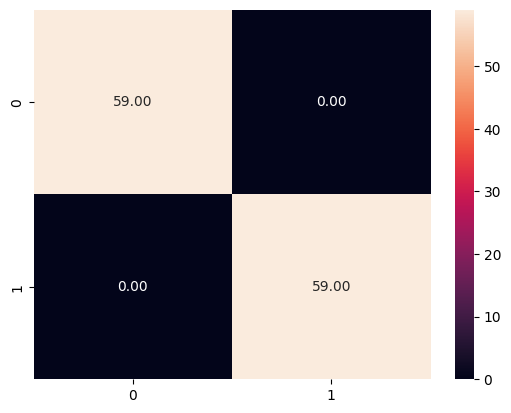

n_pops=2
(2, 2, 300, 300)


Compute metrics:  13%|████████▍                                                      | 16/120 [00:00<00:00, 155.06it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 212.02it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        60
           1       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 110.29it/s, val_best_score=0.333]

Compute metrics:  22%|█████████████▋                                                 | 26/120 [00:00<00:00, 255.58it/s]

Training report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.98      0.96      0.97       181

    accuracy                           0.97       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.97      0.97      0.97       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 253.50it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 112.32it/s, val_best_score=0.975]

Evaluation report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.95      0.97        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

f1 macro improvement to 0.9749843652282677



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.19it/s, val_best_score=0.975]

Compute metrics:  22%|█████████████▋                                                 | 26/120 [00:00<00:00, 253.07it/s]

Training report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       181
           1       0.98      0.97      0.97       181

    accuracy                           0.98       362
   macro avg       0.98      0.98      0.98       362
weighted avg       0.98      0.98      0.98       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 264.22it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:02, 117.81it/s, val_best_score=0.983]

Evaluation report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.97      0.98        60

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

f1 macro improvement to 0.983328702417338



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.43it/s, val_best_score=0.983]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 261.52it/s]

Training report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.98      0.96      0.97       181

    accuracy                           0.97       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.97      0.97      0.97       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 264.23it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 116.50it/s, val_best_score=0.983]

Evaluation report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.95      0.97        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.92it/s, val_best_score=0.983]

Compute metrics:  20%|████████████▌                                                  | 24/120 [00:00<00:00, 234.86it/s]

Training report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.98      0.96      0.97       181

    accuracy                           0.97       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.97      0.97      0.97       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 238.78it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 108.48it/s, val_best_score=0.983]

Evaluation report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.95      0.97        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 108.06it/s, val_best_score=0.983]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 279.20it/s]

Training report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.98      0.96      0.97       181

    accuracy                           0.97       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.97      0.97      0.97       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 266.78it/s]

Test report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.95      1.00      0.98        59

    accuracy                           0.97       118
   macro avg       0.98      0.97      0.97       118
weighted avg       0.98      0.97      0.97       118

f1 macro score on test dataset: 0.9745598275242544


<Figure size 640x480 with 0 Axes>

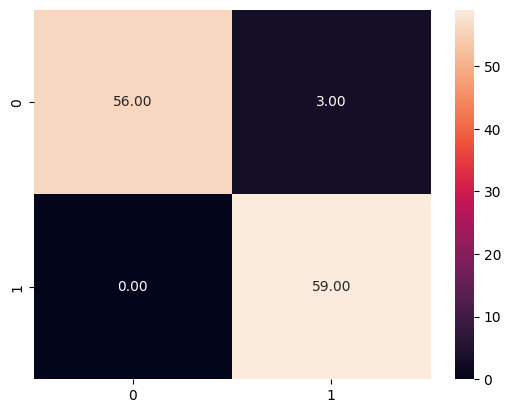

n_pops=2
(2, 2, 300, 300)


Compute metrics:  20%|████████████▌                                                  | 24/120 [00:00<00:00, 233.58it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 238.25it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      1.00      0.67        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333


Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.87it/s, val_best_score=0.333]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 269.29it/s]

Training report
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       181
           1       0.91      0.76      0.83       181

    accuracy                           0.84       362
   macro avg       0.85      0.84      0.84       362
weighted avg       0.85      0.84      0.84       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 260.26it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 116.38it/s, val_best_score=0.839]

Evaluation report
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        60
           1       0.96      0.72      0.82        60

    accuracy                           0.84       120
   macro avg       0.86      0.84      0.84       120
weighted avg       0.86      0.84      0.84       120

f1 macro improvement to 0.8391534391534392



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.54it/s, val_best_score=0.839]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 273.66it/s]


Training report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       181
           1       0.88      0.83      0.86       181

    accuracy                           0.86       362
   macro avg       0.86      0.86      0.86       362
weighted avg       0.86      0.86      0.86       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 259.63it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 113.19it/s, val_best_score=0.883]

Evaluation report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        60
           1       0.91      0.85      0.88        60

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120

f1 macro improvement to 0.8832035595105672



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.03it/s, val_best_score=0.883]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 271.14it/s]

Training report
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       181
           1       0.90      0.80      0.85       181

    accuracy                           0.85       362
   macro avg       0.86      0.85      0.85       362
weighted avg       0.86      0.85      0.85       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 247.94it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 112.93it/s, val_best_score=0.883]

Evaluation report
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        60
           1       0.92      0.77      0.84        60

    accuracy                           0.85       120
   macro avg       0.86      0.85      0.85       120
weighted avg       0.86      0.85      0.85       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 107.98it/s, val_best_score=0.883]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 269.44it/s]


Training report
              precision    recall  f1-score   support

           0       0.84      0.90      0.86       181
           1       0.89      0.82      0.85       181

    accuracy                           0.86       362
   macro avg       0.86      0.86      0.86       362
weighted avg       0.86      0.86      0.86       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 265.31it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 106.61it/s, val_best_score=0.883]

Evaluation report
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        60
           1       0.91      0.82      0.86        60

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 110.78it/s, val_best_score=0.883]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 275.17it/s]

Training report
              precision    recall  f1-score   support

           0       0.84      0.90      0.86       181
           1       0.89      0.82      0.85       181

    accuracy                           0.86       362
   macro avg       0.86      0.86      0.86       362
weighted avg       0.86      0.86      0.86       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 271.13it/s]

Test report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        59
           1       0.87      0.88      0.87        59

    accuracy                           0.87       118
   macro avg       0.87      0.87      0.87       118
weighted avg       0.87      0.87      0.87       118

f1 macro score on test dataset: 0.8728722258134023


<Figure size 640x480 with 0 Axes>

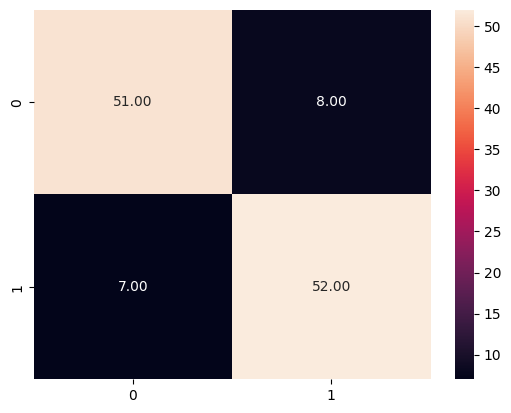

n_pops=2
(2, 2, 300, 300)


Compute metrics:  10%|██████▎                                                        | 12/120 [00:00<00:00, 117.96it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 193.57it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      1.00      0.67        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.33it/s, val_best_score=0.333]

Compute metrics:  21%|█████████████▏                                                 | 25/120 [00:00<00:00, 243.33it/s]

Training report
              precision    recall  f1-score   support

           0       0.81      0.51      0.62       181
           1       0.64      0.88      0.74       181

    accuracy                           0.69       362
   macro avg       0.72      0.69      0.68       362
weighted avg       0.72      0.69      0.68       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 254.78it/s]

Training samples:   3%|█▎                                       | 12/362 [00:00<00:02, 117.65it/s, val_best_score=0.68]

Evaluation report
              precision    recall  f1-score   support

           0       0.81      0.50      0.62        60
           1       0.64      0.88      0.74        60

    accuracy                           0.69       120
   macro avg       0.72      0.69      0.68       120
weighted avg       0.72      0.69      0.68       120

f1 macro improvement to 0.6799077211448344



Training samples: 100%|████████████████████████████████████████| 362/362 [00:03<00:00, 113.59it/s, val_best_score=0.68]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 269.17it/s]

Training report
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       181
           1       0.70      0.76      0.73       181

    accuracy                           0.72       362
   macro avg       0.72      0.72      0.72       362
weighted avg       0.72      0.72      0.72       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 260.81it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 116.58it/s, val_best_score=0.767]

Evaluation report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        60
           1       0.77      0.77      0.77        60

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

f1 macro improvement to 0.7666666666666667



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.93it/s, val_best_score=0.767]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 273.84it/s]

Training report
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       181
           1       0.70      0.76      0.73       181

    accuracy                           0.72       362
   macro avg       0.72      0.72      0.72       362
weighted avg       0.72      0.72      0.72       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 259.65it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 114.39it/s, val_best_score=0.767]

Evaluation report
              precision    recall  f1-score   support

           0       0.76      0.73      0.75        60
           1       0.74      0.77      0.75        60

    accuracy                           0.75       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.75      0.75      0.75       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 106.38it/s, val_best_score=0.767]

Compute metrics:  22%|█████████████▋                                                 | 26/120 [00:00<00:00, 257.91it/s]

Training report
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       181
           1       0.71      0.76      0.73       181

    accuracy                           0.72       362
   macro avg       0.72      0.72      0.72       362
weighted avg       0.72      0.72      0.72       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 261.35it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 114.54it/s, val_best_score=0.767]

Evaluation report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        60
           1       0.77      0.77      0.77        60

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 110.70it/s, val_best_score=0.767]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 276.69it/s]

Training report
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       181
           1       0.71      0.76      0.73       181

    accuracy                           0.72       362
   macro avg       0.72      0.72      0.72       362
weighted avg       0.72      0.72      0.72       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 264.29it/s]

Test report
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        59
           1       0.64      0.76      0.70        59

    accuracy                           0.67       118
   macro avg       0.68      0.67      0.67       118
weighted avg       0.68      0.67      0.67       118

f1 macro score on test dataset: 0.66659421864812


<Figure size 640x480 with 0 Axes>

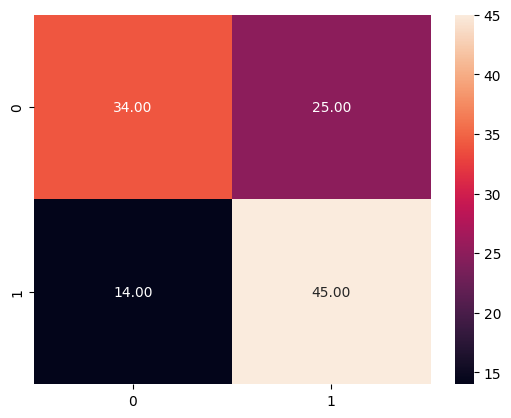

n_pops=2
(2, 2, 300, 300)


Compute metrics:  13%|████████▍                                                      | 16/120 [00:00<00:00, 159.67it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 191.53it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        60
           1       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.53it/s, val_best_score=0.333]

Compute metrics: 100%|██████████████████████████████████████████████████████████████| 362/362 [00:01<00:00, 247.83it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Training report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       181
           1       0.00      0.00      0.00       181

    accuracy                           0.50       362
   macro avg       0.25      0.50      0.33       362
weighted avg       0.25      0.50      0.33       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 239.71it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        60
           1       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 110.54it/s, val_best_score=0.333]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 265.35it/s]

Training report
              precision    recall  f1-score   support

           0       0.53      0.63      0.57       181
           1       0.54      0.44      0.48       181

    accuracy                           0.53       362
   macro avg       0.53      0.53      0.53       362
weighted avg       0.53      0.53      0.53       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 265.71it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 113.72it/s, val_best_score=0.474]

Evaluation report
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        60
           1       0.47      0.43      0.45        60

    accuracy                           0.48       120
   macro avg       0.47      0.48      0.47       120
weighted avg       0.47      0.47      0.47       120

f1 macro improvement to 0.4740869565217392



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.14it/s, val_best_score=0.474]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 269.15it/s]

Training report
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       181
           1       0.79      0.06      0.11       181

    accuracy                           0.52       362
   macro avg       0.65      0.52      0.39       362
weighted avg       0.65      0.52      0.39       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 262.18it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:02, 116.75it/s, val_best_score=0.474]

Evaluation report
              precision    recall  f1-score   support

           0       0.49      0.97      0.65        60
           1       0.00      0.00      0.00        60

    accuracy                           0.48       120
   macro avg       0.25      0.48      0.33       120
weighted avg       0.25      0.48      0.33       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.69it/s, val_best_score=0.474]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 271.20it/s]

Training report
              precision    recall  f1-score   support

           0       0.52      0.91      0.66       181
           1       0.65      0.18      0.28       181

    accuracy                           0.54       362
   macro avg       0.59      0.54      0.47       362
weighted avg       0.59      0.54      0.47       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 267.07it/s]

Test report
              precision    recall  f1-score   support

           0       0.52      0.66      0.58        59
           1       0.53      0.39      0.45        59

    accuracy                           0.53       118
   macro avg       0.53      0.53      0.52       118
weighted avg       0.53      0.53      0.52       118

f1 macro score on test dataset: 0.5165349721978344


<Figure size 640x480 with 0 Axes>

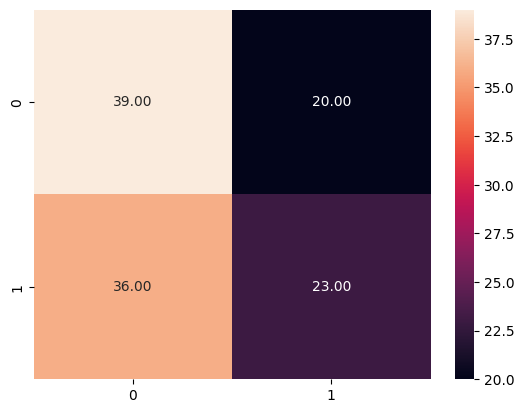

n_pops=2
(2, 2, 300, 300)


Compute metrics:  13%|████████▍                                                      | 16/120 [00:00<00:00, 157.99it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 201.70it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        60
           1       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 111.83it/s, val_best_score=0.333]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 271.10it/s]

Training report
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       181
           1       0.50      1.00      0.67       181

    accuracy                           0.51       362
   macro avg       0.75      0.51      0.35       362
weighted avg       0.75      0.51      0.35       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 267.09it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 115.68it/s, val_best_score=0.352]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      0.02      0.03        60
           1       0.50      1.00      0.67        60

    accuracy                           0.51       120
   macro avg       0.75      0.51      0.35       120
weighted avg       0.75      0.51      0.35       120

f1 macro improvement to 0.3515889733492078



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.98it/s, val_best_score=0.352]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 264.00it/s]

Training report
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       181
           1       0.65      0.69      0.67       181

    accuracy                           0.66       362
   macro avg       0.66      0.66      0.66       362
weighted avg       0.66      0.66      0.66       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 251.57it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 111.51it/s, val_best_score=0.717]

Evaluation report
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        60
           1       0.72      0.72      0.72        60

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.72      0.72      0.72       120

f1 macro improvement to 0.7166666666666667



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.70it/s, val_best_score=0.717]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 266.72it/s]

Training report
              precision    recall  f1-score   support

           0       0.64      0.67      0.66       181
           1       0.66      0.63      0.64       181

    accuracy                           0.65       362
   macro avg       0.65      0.65      0.65       362
weighted avg       0.65      0.65      0.65       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 261.17it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 112.92it/s, val_best_score=0.717]

Evaluation report
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        60
           1       0.74      0.67      0.70        60

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.72      0.72      0.72       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.32it/s, val_best_score=0.717]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 265.42it/s]

Training report
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       181
           1       0.65      0.64      0.64       181

    accuracy                           0.65       362
   macro avg       0.65      0.65      0.65       362
weighted avg       0.65      0.65      0.65       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 249.69it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 115.64it/s, val_best_score=0.717]

Evaluation report
              precision    recall  f1-score   support

           0       0.70      0.75      0.73        60
           1       0.73      0.68      0.71        60

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72       120
weighted avg       0.72      0.72      0.72       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.94it/s, val_best_score=0.717]

Compute metrics:  23%|██████████████▍                                                | 27/118 [00:00<00:00, 260.42it/s]

Training report
              precision    recall  f1-score   support

           0       0.64      0.67      0.66       181
           1       0.66      0.63      0.64       181

    accuracy                           0.65       362
   macro avg       0.65      0.65      0.65       362
weighted avg       0.65      0.65      0.65       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 263.89it/s]

Test report
              precision    recall  f1-score   support

           0       0.62      0.47      0.54        59
           1       0.58      0.71      0.64        59

    accuracy                           0.59       118
   macro avg       0.60      0.59      0.59       118
weighted avg       0.60      0.59      0.59       118

f1 macro score on test dataset: 0.5874125874125874


<Figure size 640x480 with 0 Axes>

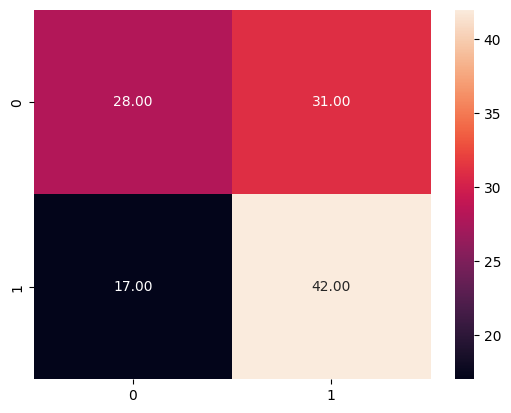

n_pops=2
(2, 2, 300, 300)


Compute metrics:  12%|███████▉                                                       | 15/120 [00:00<00:00, 145.26it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 199.33it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      1.00      0.67        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333


Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.00it/s, val_best_score=0.333]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 265.35it/s]

Training report
              precision    recall  f1-score   support

           0       0.71      0.80      0.76       181
           1       0.77      0.68      0.72       181

    accuracy                           0.74       362
   macro avg       0.74      0.74      0.74       362
weighted avg       0.74      0.74      0.74       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 255.39it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 109.71it/s, val_best_score=0.767]

Evaluation report
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        60
           1       0.76      0.78      0.77        60

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

f1 macro improvement to 0.766601833842734



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.43it/s, val_best_score=0.767]

Compute metrics:  20%|████████████▌                                                  | 24/120 [00:00<00:00, 235.99it/s]

Training report
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       181
           1       0.77      0.69      0.72       181

    accuracy                           0.74       362
   macro avg       0.74      0.74      0.74       362
weighted avg       0.74      0.74      0.74       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 237.57it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 104.63it/s, val_best_score=0.767]

Evaluation report
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        60
           1       0.76      0.78      0.77        60

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 109.08it/s, val_best_score=0.767]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 272.60it/s]

Training report
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       181
           1       0.75      0.76      0.75       181

    accuracy                           0.75       362
   macro avg       0.75      0.75      0.75       362
weighted avg       0.75      0.75      0.75       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 262.43it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 113.03it/s, val_best_score=0.782]

Evaluation report
              precision    recall  f1-score   support

           0       0.83      0.72      0.77        60
           1       0.75      0.85      0.80        60

    accuracy                           0.78       120
   macro avg       0.79      0.78      0.78       120
weighted avg       0.79      0.78      0.78       120

f1 macro improvement to 0.7823660714285714



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.49it/s, val_best_score=0.782]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 267.98it/s]

Training report
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       181
           1       0.75      0.76      0.75       181

    accuracy                           0.75       362
   macro avg       0.75      0.75      0.75       362
weighted avg       0.75      0.75      0.75       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 261.68it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 110.86it/s, val_best_score=0.782]

Evaluation report
              precision    recall  f1-score   support

           0       0.83      0.72      0.77        60
           1       0.75      0.85      0.80        60

    accuracy                           0.78       120
   macro avg       0.79      0.78      0.78       120
weighted avg       0.79      0.78      0.78       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.20it/s, val_best_score=0.782]

Compute metrics:  23%|██████████████▍                                                | 27/118 [00:00<00:00, 265.46it/s]

Training report
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       181
           1       0.75      0.76      0.75       181

    accuracy                           0.75       362
   macro avg       0.75      0.75      0.75       362
weighted avg       0.75      0.75      0.75       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 264.50it/s]

Test report
              precision    recall  f1-score   support

           0       0.76      0.75      0.75        59
           1       0.75      0.76      0.76        59

    accuracy                           0.75       118
   macro avg       0.75      0.75      0.75       118
weighted avg       0.75      0.75      0.75       118

f1 macro score on test dataset: 0.7542196365725777


<Figure size 640x480 with 0 Axes>

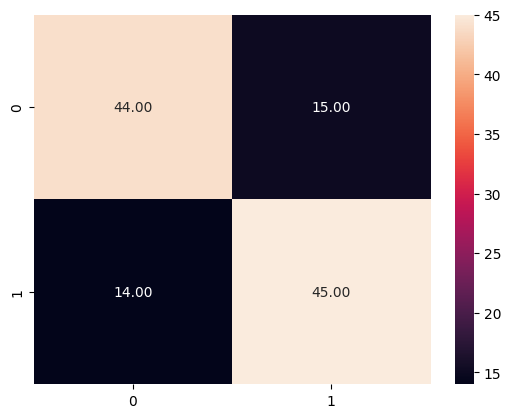

n_pops=2
(2, 2, 300, 300)


Compute metrics:  12%|███████▎                                                       | 14/120 [00:00<00:00, 136.96it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 203.22it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.50      1.00      0.67        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.90it/s, val_best_score=0.333]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 262.79it/s]

Training report
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       181
           1       0.81      0.91      0.86       181

    accuracy                           0.85       362
   macro avg       0.85      0.85      0.85       362
weighted avg       0.85      0.85      0.85       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 259.40it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 112.93it/s, val_best_score=0.874]

Evaluation report
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        60
           1       0.82      0.97      0.89        60

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.87       120
weighted avg       0.89      0.88      0.87       120

f1 macro improvement to 0.8739407521535122



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.68it/s, val_best_score=0.874]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 271.06it/s]

Training report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       181
           1       0.85      0.89      0.87       181

    accuracy                           0.87       362
   macro avg       0.87      0.87      0.87       362
weighted avg       0.87      0.87      0.87       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 258.76it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 113.45it/s, val_best_score=0.892]

Evaluation report
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        60
           1       0.87      0.92      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120

f1 macro improvement to 0.89159891598916



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.14it/s, val_best_score=0.892]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 269.15it/s]

Training report
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       181
           1       0.88      0.89      0.88       181

    accuracy                           0.88       362
   macro avg       0.88      0.88      0.88       362
weighted avg       0.88      0.88      0.88       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 259.45it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 111.78it/s, val_best_score=0.892]

Evaluation report
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        60
           1       0.87      0.92      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.05it/s, val_best_score=0.892]

Compute metrics:  21%|█████████████▏                                                 | 25/120 [00:00<00:00, 248.12it/s]


Training report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       181
           1       0.87      0.87      0.87       181

    accuracy                           0.87       362
   macro avg       0.87      0.87      0.87       362
weighted avg       0.87      0.87      0.87       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 254.03it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 107.61it/s, val_best_score=0.892]

Evaluation report
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        60
           1       0.87      0.92      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 108.34it/s, val_best_score=0.892]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 275.12it/s]

Training report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       181
           1       0.87      0.87      0.87       181

    accuracy                           0.87       362
   macro avg       0.87      0.87      0.87       362
weighted avg       0.87      0.87      0.87       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 265.70it/s]

Test report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        59
           1       0.84      0.92      0.88        59

    accuracy                           0.87       118
   macro avg       0.88      0.87      0.87       118
weighted avg       0.88      0.87      0.87       118

f1 macro score on test dataset: 0.8726527088279732


<Figure size 640x480 with 0 Axes>

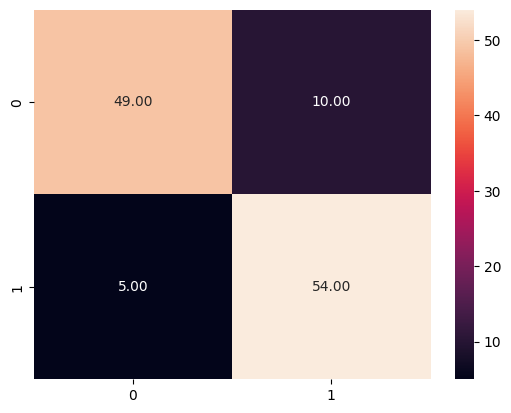

n_pops=2
(2, 2, 300, 300)


Compute metrics:  11%|██████▊                                                        | 13/120 [00:00<00:00, 126.48it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 203.62it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        60
           1       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 114.04it/s, val_best_score=0.333]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 261.59it/s]

Training report
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       181
           1       0.90      0.98      0.94       181

    accuracy                           0.94       362
   macro avg       0.94      0.94      0.94       362
weighted avg       0.94      0.94      0.94       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 257.49it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 109.86it/s, val_best_score=0.916]

Evaluation report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        60
           1       0.88      0.97      0.92        60

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120

f1 macro improvement to 0.9164578111946533



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 111.70it/s, val_best_score=0.916]

Compute metrics:  21%|█████████████▏                                                 | 25/120 [00:00<00:00, 245.83it/s]

Training report
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       181
           1       0.95      0.97      0.96       181

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 249.75it/s]

Training samples:   3%|█▎                                       | 12/362 [00:00<00:03, 112.56it/s, val_best_score=0.95]

Evaluation report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.94      0.97      0.95        60

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

f1 macro improvement to 0.9499861072520146



Training samples: 100%|████████████████████████████████████████| 362/362 [00:03<00:00, 113.81it/s, val_best_score=0.95]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 265.42it/s]

Training report
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       181
           1       0.93      0.98      0.95       181

    accuracy                           0.95       362
   macro avg       0.95      0.95      0.95       362
weighted avg       0.95      0.95      0.95       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 260.80it/s]

Training samples:   3%|█▏                                       | 11/362 [00:00<00:03, 109.80it/s, val_best_score=0.95]

Evaluation report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.94      0.97      0.95        60

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

Metric was not improved for the 1th time



Training samples: 100%|████████████████████████████████████████| 362/362 [00:03<00:00, 114.31it/s, val_best_score=0.95]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 266.66it/s]

Training report
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       181
           1       0.95      0.97      0.96       181

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 261.82it/s]

Training samples:   3%|█▎                                       | 12/362 [00:00<00:03, 111.23it/s, val_best_score=0.95]

Evaluation report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.94      0.97      0.95        60

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

Metric was not improved for the 2th time



Training samples: 100%|████████████████████████████████████████| 362/362 [00:03<00:00, 113.43it/s, val_best_score=0.95]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 273.77it/s]

Training report
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       181
           1       0.95      0.97      0.96       181

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 266.20it/s]

Test report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        59
           1       0.95      0.95      0.95        59

    accuracy                           0.95       118
   macro avg       0.95      0.95      0.95       118
weighted avg       0.95      0.95      0.95       118

f1 macro score on test dataset: 0.9491525423728814


<Figure size 640x480 with 0 Axes>

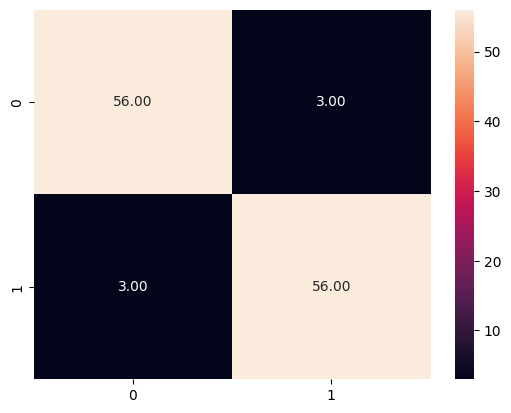

n_pops=2
(2, 2, 300, 300)


Compute metrics:  11%|██████▊                                                        | 13/120 [00:00<00:00, 129.45it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 192.75it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        60
           1       0.00      0.00      0.00        60

    accuracy                           0.50       120
   macro avg       0.25      0.50      0.33       120
weighted avg       0.25      0.50      0.33       120

f1 macro improvement to 0.3333333333333333



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.40it/s, val_best_score=0.333]

Compute metrics:  21%|█████████████▏                                                 | 25/120 [00:00<00:00, 240.94it/s]

Training report
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       181
           1       0.95      0.99      0.97       181

    accuracy                           0.97       362
   macro avg       0.97      0.97      0.97       362
weighted avg       0.97      0.97      0.97       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 244.38it/s]

Training samples:   3%|█▎                                      | 12/362 [00:00<00:03, 113.09it/s, val_best_score=0.983]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.97      1.00      0.98        60

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

f1 macro improvement to 0.983328702417338



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.46it/s, val_best_score=0.983]

Compute metrics:  22%|██████████████▏                                                | 27/120 [00:00<00:00, 266.58it/s]

Training report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       181
           1       0.95      0.96      0.95       181

    accuracy                           0.95       362
   macro avg       0.95      0.95      0.95       362
weighted avg       0.95      0.95      0.95       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 248.29it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 109.81it/s, val_best_score=0.983]

Evaluation report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.98      0.97      0.97        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 113.06it/s, val_best_score=0.983]

Compute metrics:  23%|██████████████▋                                                | 28/120 [00:00<00:00, 275.27it/s]

Training report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       181
           1       0.96      0.95      0.95       181

    accuracy                           0.95       362
   macro avg       0.95      0.95      0.95       362
weighted avg       0.95      0.95      0.95       362




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 261.30it/s]

Training samples:   3%|█▏                                      | 11/362 [00:00<00:03, 109.84it/s, val_best_score=0.983]

Evaluation report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.97      0.98        60

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████| 362/362 [00:03<00:00, 112.42it/s, val_best_score=0.983]

Compute metrics:  24%|██████████████▉                                                | 28/118 [00:00<00:00, 268.58it/s]

Training report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       181
           1       0.96      0.96      0.96       181

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 259.45it/s]

Test report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        59
           1       0.97      1.00      0.98        59

    accuracy                           0.98       118
   macro avg       0.98      0.98      0.98       118
weighted avg       0.98      0.98      0.98       118

f1 macro score on test dataset: 0.9830459770114942


<Figure size 640x480 with 0 Axes>

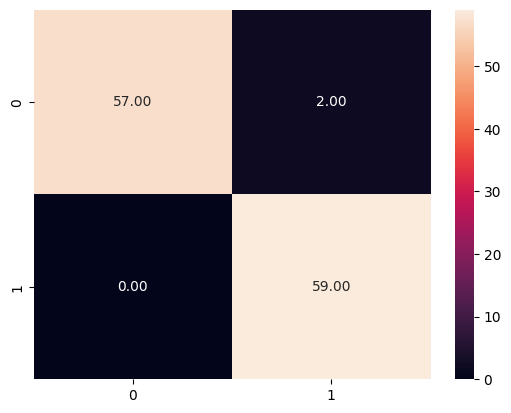

In [23]:
cross_class_prob = 3.41394026e-03

cross_class_probs = [(cross_class_prob + coeff) for coeff in np.linspace(start=3.41394026e-03 / 2, stop=0.1, num=10)]

res = []

for tmp_cross_class_prob in cross_class_probs:

#     probs = np.array([[2.77715566e-01, tmp_cross_class_prob], [tmp_cross_class_prob, 5.02849789e-02]])
#     weights = np.array([[14.90908489,  1.94265021], [1.94265021, 12.70004896]])
    probs = np.array([[5.02849789e-02, tmp_cross_class_prob], [tmp_cross_class_prob, 5.02849789e-02]])
    weights = np.array([[1.94265021,  1.94265021], [1.94265021, 1.94265021]])
    
    ns = NullSimulator(2, probs, weights) # use first two classes of NC dataset as background

    means, counts, pop_index = ns.generate_matrices([300]*2)

    ns.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

    dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

    dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

    dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_100')

    trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\nc_null", 2, 20)

    res.append(trainer.run())

In [13]:
cross_class_probs

[0.00682788052,
 0.11644855382444444,
 0.22606922712888888,
 0.33568990043333335,
 0.4453105737377778,
 0.5549312470422222,
 0.6645519203466665,
 0.774172593651111,
 0.8837932669555555,
 0.99341394026]

In [22]:
res

[1.0, 0.9745744451626804, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [20]:
print(max(cross_class_probs), min(cross_class_probs), len(cross_class_probs))

0.99341394026 0.00512091039 100


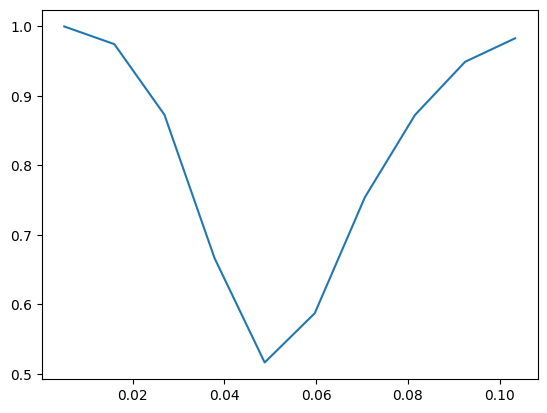

In [25]:
import matplotlib.pyplot as plt
plt.plot(cross_class_probs, res)


In [22]:
ns.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

In [23]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\null_simulations\nc_null_simulations_100.csv")

In [24]:
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

In [25]:
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'nc_null_sim_100')

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "genlink.py", line 191:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

Isolated test node found! Restart with different seed or this node will be ignored.


In [26]:
trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\nc_null", 10, 20)

Compute metrics:   0%|                                                                          | 0/40 [00:00<?, ?it/s]

Training for data: nc_null_sim_100



Compute metrics: 100%|█████████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.00it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

f1 macro improvement to 1.0



Training samples: 100%|████████████████████████████████████████████| 122/122 [00:03<00:00, 32.83it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 272.94it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 1th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 115.78it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 246.78it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 2th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.28it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 265.75it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 3th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 117.21it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 216.65it/s]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122





Training samples:  10%|████▎                                       | 12/122 [00:00<00:00, 114.00it/s, val_best_score=1]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 4th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 112.73it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 263.94it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 5th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.86it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 264.24it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 6th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.63it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 261.40it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 7th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 118.57it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 275.84it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 8th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 114.14it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 274.11it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 9th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.41it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 260.48it/s]

Training samples:   0%|                                                      | 0/122 [00:00<?, ?it/s, val_best_score=1]

Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Metric was not improved for the 10th time



Training samples: 100%|███████████████████████████████████████████| 122/122 [00:01<00:00, 116.19it/s, val_best_score=1]

Compute metrics: 100%|████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 264.46it/s]


Training report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        61

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

f1 macro score on test dataset: 1.0


<Figure size 640x480 with 0 Axes>

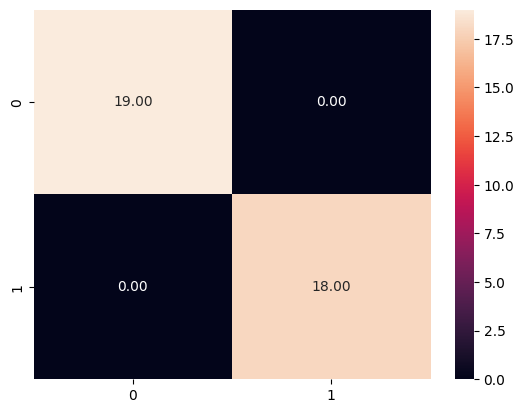

In [27]:
trainer.run()

# NC simulations

In [10]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\nc\raw\NC_graph_rel.csv")
# dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia.csv")

In [11]:
dp.classes

['чеченцы',
 'кабардинцы,черкесы,адыгейцы',
 'карачаевцы,балкарцы',
 'ингуши',
 'дагестанские народы',
 'осетины',
 'кумыки',
 'ногайцы']

In [12]:
dp.compute_simulation_params()

C:\HSE\genotek-nationality-analysis\genlink.py:328: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean() - self.offset
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\HSE\genotek-nationality-analysis\genlink.py:328: RuntimeWarning: Mean of empty slice.
  self.mean_weight[i, j] = real_connections_df['ibd_sum'].to_numpy().mean() - self.offset
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
dp.edge_probs

array([[2.77715566e-01, 3.41394026e-03, 5.38555692e-03, 1.31174089e-01,
        6.12725844e-03, 1.15384615e-02, 1.52046784e-02, 1.08892922e-03],
       [3.41394026e-03, 5.02849789e-02, 2.24701446e-02, 7.92619543e-03,
        2.01694232e-04, 1.66320166e-02, 7.50750751e-04, 5.12581547e-03],
       [5.38555692e-03, 2.24701446e-02, 3.61696306e-01, 1.31932021e-02,
        2.60326276e-04, 3.89087657e-02, 5.81395349e-03, 9.22213312e-03],
       [1.31174089e-01, 7.92619543e-03, 1.31932021e-02, 4.75113122e-01,
        2.58323766e-03, 7.10059172e-02, 5.34188034e-03, 1.32625995e-03],
       [6.12725844e-03, 2.01694232e-04, 2.60326276e-04, 2.58323766e-03,
        3.28831474e-02, 1.14810563e-03, 4.14593698e-04, 2.57334020e-04],
       [1.15384615e-02, 1.66320166e-02, 3.89087657e-02, 7.10059172e-02,
        1.14810563e-03, 2.28506787e-01, 2.13675214e-03, 4.64190981e-03],
       [1.52046784e-02, 7.50750751e-04, 5.81395349e-03, 5.34188034e-03,
        4.14593698e-04, 2.13675214e-03, 1.58333333e-01, 0.

In [14]:
dp.mean_weight

array([[14.90908489,  1.94265021,  2.30568932,  7.77972619,  2.61010051,
         2.93902175,  1.65329692,  2.14949   ],
       [ 1.94265021, 12.70004896,  3.5279301 ,  3.07051311,  1.3875125 ,
         3.66120656,  0.867145  ,  1.32968409],
       [ 2.30568932,  3.5279301 , 31.37447639,  2.85508017,  2.20767333,
         4.03104862,  1.64853889,  4.05216522],
       [ 7.77972619,  3.07051311,  2.85508017, 19.63135611,  1.25224833,
         4.60230609,  1.91038   ,  5.65972   ],
       [ 2.61010051,  1.3875125 ,  2.20767333,  1.25224833, 36.52264036,
         4.34636875,  3.7234    ,  2.2861    ],
       [ 2.93902175,  3.66120656,  4.03104862,  4.60230609,  4.34636875,
        13.66507809,  3.84755   ,  1.68632286],
       [ 1.65329692,  0.867145  ,  1.64853889,  1.91038   ,  3.7234    ,
         3.84755   , 12.48511053, -8.        ],
       [ 2.14949   ,  1.32968409,  4.05216522,  5.65972   ,  2.2861    ,
         1.68632286, -8.        , 17.22307933]])

In [11]:
means, counts, pop_index = dp.generate_matrices([500]*3)

n_pops=3
(3, 3, 500, 500)
pop_i=0 pop_j=0
total_segments=15128
pop_i=1 pop_j=0
total_segments=2774
pop_i=1 pop_j=1
total_segments=19160
pop_i=2 pop_j=0
total_segments=340
pop_i=2 pop_j=1
total_segments=788
pop_i=2 pop_j=2
total_segments=7304


In [12]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [13]:
import numpy as np
check_symmetric(counts)

True

In [7]:
print(counts.shape)

(800, 800)


In [16]:
dp.classes

['Swedes', 'Norwegians', 'Danes']

In [14]:
dp.simulate_graph(means, counts, pop_index, r"C:\HSE\genotek-nationality-analysis\data\generated_sc\raw\simulated_sc_500.csv")

In [17]:
for i in range(3500, 4000):
    print(G.nodes[i]['y'])

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [11]:
dp.edge_probs.round(2)

array([[0.28, 0.  , 0.01, 0.13, 0.01, 0.01, 0.02, 0.  ],
       [0.  , 0.05, 0.02, 0.01, 0.  , 0.02, 0.  , 0.01],
       [0.01, 0.02, 0.36, 0.01, 0.  , 0.04, 0.01, 0.01],
       [0.13, 0.01, 0.01, 0.48, 0.  , 0.07, 0.01, 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.01, 0.02, 0.04, 0.07, 0.  , 0.23, 0.  , 0.  ],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  , 0.16, 0.  ],
       [0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.11]])

In [7]:
dp.classes

['чеченцы',
 'кабардинцы,черкесы,адыгейцы',
 'карачаевцы,балкарцы',
 'ингуши',
 'дагестанские народы',
 'осетины',
 'кумыки',
 'ногайцы']

In [11]:
pop_index

array([0, 0, 0, ..., 7, 7, 7])

In [6]:
df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\data\generated_we\raw\simulated_we.csv", sep=',')
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum
0,node_19,node_7,English,English,10.098513
1,node_28,node_14,English,English,17.500695
2,node_29,node_0,English,English,10.148421
3,node_30,node_1,English,English,12.850058
4,node_30,node_22,English,English,8.544812
...,...,...,...,...,...
6091,node_1999,node_1865,Belgium,Belgium,12.662206
6092,node_1999,node_1886,Belgium,Belgium,31.445615
6093,node_1999,node_1887,Belgium,Belgium,9.249153
6094,node_1999,node_1905,Belgium,Belgium,10.947118


In [7]:
df[df.node_id2=='node_0'].label_id2.unique()

array(['English'], dtype=object)

In [11]:
df[((df.label_id1 == 'чеченцы') & (df.label_id2 == 'кабардинцы,черкесы,адыгейцы')) | ((df.label_id1 == 'кабардинцы,черкесы,адыгейцы') & (df.label_id2 == 'чеченцы'))].ibd_sum.mean()

10.094627886661257

In [9]:
df[(df.label_id1 == 'English') & (df.label_id2 == 'English')].ibd_sum.mean()

11.176547184133804

In [50]:
(np.random.default_rng().exponential(scale=4, size=1000)+20).mean()

23.869373102413423

# WE

In [2]:
# df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Western-Europe_weights_partial_labels.csv")
# df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Volga_weights_partial_labels.csv")
df = pd.read_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia_weights_partial_labels.csv")
df

,node_id1,node_id2,ibd_sum,ibd_n,ibd_max,label_id1,label_id2
0,node_2,node_1829,9.50609,1,9.50609,Estonians,Swedes
1,node_2,node_1837,9.29771,1,9.29771,Estonians,Swedes
2,node_2,node_8869,10.65770,1,10.65770,Estonians,Swedes
3,node_2,node_8891,8.23524,1,8.23524,Estonians,Swedes
4,node_2,node_11641,13.71090,1,13.71090,Estonians,Swedes
...,...,...,...,...,...,...,...
33201,node_11652,node_15314,9.14623,1,9.14623,Swedes,Russians
33202,node_11653,node_13240,8.59061,1,8.59061,Swedes,Russians
33203,node_11653,node_12704,8.69799,1,8.69799,Swedes,"Karelians,Veps"
33204,node_11653,node_12737,11.75780,1,11.75780,Swedes,"Tatars,Volga-Tatars,Mishar-Tatars,Kryashens"


In [3]:
df.label_id1.unique()

array(['Estonians', 'Poles', 'Dolgans,Yakuts', 'Kazakhs',
       'Udmurts,Besermyan', 'Uzbeks',
       'Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Ket', 'Mordvins',
       'Bashkirs', 'Kabardians,Cherkess,Adygeans', 'Kyrgyz',
       'Karelians,Veps', 'Belarusians', 'Ukrainians', 'Chuvash', 'Komi',
       'Moldovans', 'Evenks', 'Ashkenazim', 'English', 'Swedes', 'Roma',
       'Basques', 'Balkan', 'Germans', 'Armenians,Hemshins', 'French',
       'Finns', 'Sephardim', 'Scots', 'Puerto-Ricans', 'Spaniards',
       'Tamils', 'Pashtuns', 'Khanty,Mansi', 'Albanians,Greeks',
       'Mexicans', 'Norwegians', 'Ossetians', 'Lithuanians', 'Sami',
       'Czechs,Slovaks', 'Danes', 'Tuscans', 'Belgium'], dtype=object)

In [24]:
df.ibd_sum.min()

8.00001

In [5]:
# df = df[['node_id1','node_id2','label_id1','label_id2','ibd_sum','ibd_n','ibd_max']]
# df

In [4]:
selected_rows = []
# sel_pop = ['English', 'Germans', 'French', 'Belgium']
# sel_pop = ['Tatars,Volga-Tatars,Mishar-Tatars,Kryashens', 'Chuvash', 'Udmurts,Besermyan', 'Mari']
sel_pop = ['Norwegians', 'Swedes', 'Danes']

for i in range(df.shape[0]):
    row = df.iloc[i, 5:]
    if row[0] in sel_pop and row[1] in sel_pop:
        selected_rows.append(True)
    else:
        selected_rows.append(False)

In [6]:
df_mod = df[selected_rows][['node_id1', 'node_id2', 'label_id1', 'label_id2',  'ibd_sum', 'ibd_n', 'ibd_max']]
df_mod

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
498,node_1799,node_1821,Swedes,Swedes,18.25960,1,18.25960
499,node_1799,node_1841,Swedes,Swedes,8.35242,1,8.35242
500,node_1799,node_1867,Swedes,Swedes,9.57823,1,9.57823
523,node_1799,node_8828,Swedes,Swedes,11.78040,1,11.78040
524,node_1799,node_8832,Swedes,Swedes,11.22940,1,11.22940
...,...,...,...,...,...,...,...
33170,node_11643,node_11647,Swedes,Swedes,10.38140,1,10.38140
33171,node_11643,node_11648,Swedes,Swedes,10.26240,1,10.26240
33175,node_11645,node_11651,Swedes,Swedes,10.72090,1,10.72090
33180,node_11646,node_11651,Swedes,Swedes,15.19660,2,8.40791


In [7]:
df_mod.to_csv(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Scandinavia.csv", index=False)

# runs

In [84]:
def set_global_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [85]:
set_global_seed(42)

In [12]:
# torch.load(r"C:\HSE\genotek-nationality-analysis\data\mapping_indices.pt")

In [2]:
dp = DataProcessor(r"C:\HSE\genotek-nationality-analysis\22_graphs_ibd_weigths\Western-Europe.csv")

In [3]:
dp.df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n,ibd_max
0,0,76,0,0,10.65130,1,10.65130
1,0,85,0,0,8.51599,1,8.51599
2,0,119,0,0,11.50810,1,11.50810
3,0,371,0,0,14.50930,1,14.50930
4,0,704,0,0,9.06940,1,9.06940
...,...,...,...,...,...,...,...
22041,3395,3472,5,5,8.15428,1,8.15428
22042,3396,3846,5,5,8.40182,1,8.40182
22043,3397,3888,5,5,8.17397,1,8.17397
22044,3398,3886,5,5,9.03886,1,9.03886


In [4]:
dp.generate_random_train_valid_test_nodes(0.6, 0.2, 0.2, 42)

In [88]:
nc.load_train_valid_test_nodes(r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\train_indices.pt",
                              r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\val_indices.pt",
                              r"C:\HSE\genotek-nationality-analysis\data\nc\splits\9\test_indices.pt",
                              'torch')

In [6]:
import numpy as np
tmp_df = nc.node_classes_sorted.loc[nc.node_classes_sorted['node'].isin(nc.valid_nodes)]
np.unique(tmp_df['class_id'].to_numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([19, 29, 17, 10, 26, 10,  3,  5], dtype=int64))

In [21]:
nc.train_nodes

[0,
 2,
 3,
 5,
 6,
 7,
 9,
 13,
 17,
 18,
 19,
 20,
 22,
 29,
 30,
 31,
 33,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 62,
 63,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 78,
 79,
 81,
 84,
 86,
 87,
 88,
 92,
 93,
 96,
 100,
 102,
 104,
 105,
 106,
 110,
 111,
 112,
 113,
 114,
 115,
 119,
 122,
 124,
 125,
 127,
 128,
 130,
 132,
 133,
 138,
 139,
 140,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 163,
 166,
 167,
 168,
 170,
 171,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 186,
 188,
 190,
 193,
 194,
 195,
 197,
 198,
 199,
 200,
 203,
 204,
 205,
 209,
 211,
 213,
 216,
 217,
 218,
 219,
 220,
 223,
 224,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 236,
 237,
 238,
 243,
 244,
 245,
 247,
 249,
 250,
 252,
 253,
 254,
 258,
 259,
 261,
 262,
 263,
 265,
 266,
 268,
 269,
 270,
 274,
 275,
 277,
 278,
 279,
 280,
 282,
 283,
 285,
 287,
 290,
 291,
 294,
 296,
 297,
 298,
 299,
 3

In [5]:
dp.make_train_valid_test_datasets_with_numba('one_hot', 'homogeneous', 'multiple', 'multiple', 'we_my_random')

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'test_nodes' of function 'DataProcessor.drop_rows_for_training_dataset'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "genlink.py", line 181:
    @njit(cache=True)
    def drop_rows_for_training_dataset(df, test_nodes):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:   8%|████▊                                                        | 62/791 [00:00<00:08, 83.98it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  14%|████████▏                                                   | 108/791 [00:01<00:07, 86.39it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  16%|█████████▌                                                  | 126/791 [00:01<00:07, 86.36it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  19%|███████████▌                                                | 153/791 [00:01<00:07, 83.81it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  22%|████████████▉                                               | 171/791 [00:02<00:07, 82.57it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  29%|█████████████████▋                                          | 233/791 [00:02<00:06, 86.64it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  34%|████████████████████▍                                       | 270/791 [00:03<00:06, 83.17it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  36%|█████████████████████▊                                      | 288/791 [00:03<00:06, 83.12it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  40%|███████████████████████▉                                    | 315/791 [00:03<00:05, 84.48it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  43%|█████████████████████████▉                                  | 342/791 [00:04<00:05, 81.44it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  47%|███████████████████████████▉                                | 369/791 [00:04<00:05, 81.05it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  52%|███████████████████████████████▎                            | 413/791 [00:05<00:04, 80.46it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  55%|█████████████████████████████████▎                          | 439/791 [00:05<00:04, 81.34it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  61%|████████████████████████████████████▌                       | 482/791 [00:05<00:03, 80.99it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  67%|████████████████████████████████████████                    | 528/791 [00:06<00:03, 86.50it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  70%|██████████████████████████████████████████                  | 555/791 [00:06<00:02, 82.77it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  75%|████████████████████████████████████████████▊               | 591/791 [00:07<00:02, 80.45it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  85%|███████████████████████████████████████████████████▏        | 674/791 [00:08<00:01, 81.03it/s]

Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  92%|███████████████████████████████████████████████████████     | 726/791 [00:08<00:00, 79.95it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples:  97%|██████████████████████████████████████████████████████████▎ | 769/791 [00:09<00:00, 80.32it/s]

Isolated val node found! Restart with different seed or this node will be ignored.


Make valid samples: 100%|████████████████████████████████████████████████████████████| 791/791 [00:09<00:00, 81.38it/s]


Isolated val node found! Restart with different seed or this node will be ignored.
Isolated val node found! Restart with different seed or this node will be ignored.


Make test samples:   2%|█▍                                                            | 18/788 [00:00<00:09, 81.47it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:   8%|████▊                                                         | 61/788 [00:00<00:08, 80.90it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  13%|████████▏                                                    | 105/788 [00:01<00:08, 83.30it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  18%|██████████▉                                                  | 142/788 [00:01<00:07, 86.74it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  24%|██████████████▋                                              | 189/788 [00:02<00:06, 88.59it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  25%|███████████████▍                                             | 199/788 [00:02<00:06, 90.02it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  32%|███████████████████▋                                         | 254/788 [00:03<00:06, 85.39it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  35%|█████████████████████                                        | 272/788 [00:03<00:06, 83.32it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  40%|████████████████████████▌                                    | 317/788 [00:03<00:05, 80.67it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  43%|██████████████████████████                                   | 336/788 [00:04<00:05, 84.13it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  45%|███████████████████████████▍                                 | 354/788 [00:04<00:05, 82.14it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  48%|█████████████████████████████▍                               | 381/788 [00:04<00:04, 81.90it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  52%|███████████████████████████████▋                             | 409/788 [00:04<00:04, 83.03it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  55%|█████████████████████████████████▊                           | 436/788 [00:05<00:04, 83.96it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  60%|████████████████████████████████████▌                        | 472/788 [00:05<00:03, 83.82it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  63%|██████████████████████████████████████▋                      | 499/788 [00:06<00:03, 81.46it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  66%|████████████████████████████████████████▏                    | 519/788 [00:06<00:03, 84.72it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  68%|█████████████████████████████████████████▌                   | 537/788 [00:06<00:03, 83.29it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  74%|█████████████████████████████████████████████                | 582/788 [00:07<00:02, 81.43it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  78%|███████████████████████████████████████████████▍             | 612/788 [00:07<00:01, 90.03it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  81%|█████████████████████████████████████████████████▌           | 640/788 [00:07<00:01, 83.57it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  86%|████████████████████████████████████████████████████▎        | 676/788 [00:08<00:01, 82.93it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  89%|██████████████████████████████████████████████████████▍      | 703/788 [00:08<00:01, 83.06it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  95%|█████████████████████████████████████████████████████████▉   | 748/788 [00:09<00:00, 80.56it/s]

Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples:  97%|███████████████████████████████████████████████████████████▎ | 766/788 [00:09<00:00, 83.36it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


Make test samples: 100%|█████████████████████████████████████████████████████████████| 788/788 [00:09<00:00, 82.79it/s]

Isolated test node found! Restart with different seed or this node will be ignored.
Isolated test node found! Restart with different seed or this node will be ignored.


In [7]:
torch.sum(nc.array_of_graphs_for_testing[10].x != 1.)

tensor(2705)

In [6]:
nc.array_of_graphs_for_testing[10].x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.1250, 0.1250, 0.1250,  ..., 0.1250, 0.1250, 0.1250]],
       dtype=torch.float64)

In [7]:
nc.classes

['карачаевцы,балкарцы',
 'осетины',
 'кабардинцы,черкесы,адыгейцы',
 'ингуши',
 'кумыки',
 'ногайцы',
 'чеченцы',
 'дагестанские народы']

In [11]:
trainer = Trainer(dp, TAGConv_3l_128h_w_k3, 0.0001, 5e-5, torch.nn.CrossEntropyLoss, torch.tensor([1., 1., 2., 100., 100., 1.]).to('cuda'), 10, r"C:\HSE\genotek-nationality-analysis\runs\we\my_random", 10, 20)

Compute metrics:   0%|▏                                                                | 2/754 [00:00<00:38, 19.66it/s]

Training for data: we_my_random



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:03<00:00, 242.54it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       461
           1       0.64      0.51      0.57       136
           2       0.20      0.15      0.18        78
           3       0.00      0.00      0.00         5
           4       0.00      0.17      0.00         6
           5       0.65      1.00      0.79        68

    accuracy                           0.20       754
   macro avg       0.25      0.31      0.26       754
weighted avg       0.19      0.20      0.19       754

f1 macro improvement to 0.2565239752308907



Training samples:  71%|██████████████████████████▎          | 1689/2379 [00:14<00:05, 118.71it/s, val_best_score=0.257]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.43it/s, val_best_score=0.257]

Compute metrics:  89%|█████████████████████████████████████████████████████▌      | 2124/2379 [00:08<00:00, 263.57it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 264.60it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.75it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

f1 macro improvement to 0.6144679690620096



Training samples:  71%|██████████████████████████▎          | 1695/2379 [00:14<00:05, 119.36it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.53it/s, val_best_score=0.614]

Compute metrics:  88%|████████████████████████████████████████████████████▉       | 2101/2379 [00:07<00:01, 267.45it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.62it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 267.02it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 1th time



Training samples:  72%|██████████████████████████▌          | 1708/2379 [00:14<00:05, 119.19it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.63it/s, val_best_score=0.614]

Compute metrics:  91%|██████████████████████████████████████████████████████▍     | 2156/2379 [00:08<00:00, 253.53it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.00it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 268.63it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 2th time



Training samples:  71%|██████████████████████████           | 1679/2379 [00:14<00:05, 118.69it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.53it/s, val_best_score=0.614]

Compute metrics:  86%|███████████████████████████████████████████████████▎        | 2035/2379 [00:07<00:01, 272.32it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 260.79it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 259.49it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 3th time



Training samples:  71%|██████████████████████████▎          | 1692/2379 [00:14<00:05, 117.54it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.43it/s, val_best_score=0.614]

Compute metrics:  89%|█████████████████████████████████████████████████████▍      | 2117/2379 [00:07<00:00, 265.94it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 265.06it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.21it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 4th time



Training samples:  70%|█████████████████████████▊           | 1663/2379 [00:14<00:06, 117.89it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.88it/s, val_best_score=0.614]

Compute metrics:  86%|███████████████████████████████████████████████████▊        | 2054/2379 [00:07<00:01, 263.99it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.36it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.63it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 5th time



Training samples:  71%|██████████████████████████▏          | 1687/2379 [00:14<00:05, 120.26it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.19it/s, val_best_score=0.614]

Compute metrics:  87%|████████████████████████████████████████████████████▍       | 2079/2379 [00:07<00:01, 271.60it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.67it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 261.14it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 6th time



Training samples:  71%|██████████████████████████▎          | 1689/2379 [00:14<00:05, 120.16it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:20<00:00, 118.92it/s, val_best_score=0.614]

Compute metrics:  87%|████████████████████████████████████████████████████▏       | 2069/2379 [00:07<00:01, 270.71it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.34it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 257.83it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 7th time



Training samples:  71%|██████████████████████████▏          | 1683/2379 [00:14<00:05, 120.20it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.46it/s, val_best_score=0.614]

Compute metrics:  88%|████████████████████████████████████████████████████▉       | 2101/2379 [00:08<00:01, 264.93it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 262.05it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 263.99it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 8th time



Training samples:  71%|██████████████████████████▏          | 1685/2379 [00:14<00:05, 120.29it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.14it/s, val_best_score=0.614]

Compute metrics:  87%|████████████████████████████████████████████████████▍       | 2081/2379 [00:07<00:01, 254.42it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.30it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.38it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 9th time



Training samples:  71%|██████████████████████████▏          | 1682/2379 [00:14<00:05, 119.83it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.37it/s, val_best_score=0.614]

Compute metrics:  89%|█████████████████████████████████████████████████████▍      | 2117/2379 [00:08<00:00, 262.25it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:08<00:00, 264.56it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379




Compute metrics: 100%|██████████████████████████████████████████████████████████████| 754/754 [00:02<00:00, 266.72it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.

Evaluation report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       0.93      0.92      0.93       136
           2       0.91      0.78      0.84        78
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6
           5       0.92      0.97      0.94        68

    accuracy                           0.94       754
   macro avg       0.62      0.61      0.61       754
weighted avg       0.93      0.94      0.94       754

Metric was not improved for the 10th time



Training samples:  71%|██████████████████████████▎          | 1689/2379 [00:14<00:05, 117.20it/s, val_best_score=0.614]


Training samples: 100%|█████████████████████████████████████| 2379/2379 [00:19<00:00, 119.09it/s, val_best_score=0.614]

Compute metrics:  88%|████████████████████████████████████████████████████▌       | 2082/2379 [00:07<00:01, 257.70it/s]


Compute metrics: 100%|████████████████████████████████████████████████████████████| 2379/2379 [00:09<00:00, 263.34it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Training report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1383
           1       0.82      0.93      0.87       454
           2       0.91      0.68      0.78       283
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.93      0.94      0.93       209

    accuracy                           0.92      2379
   macro avg       0.60      0.59      0.59      2379
weighted avg       0.90      0.92      0.91      2379



Compute metrics: 100%|██████████████████████████████████████████████████████████████| 735/735 [00:02<00:00, 264.67it/s]
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alex\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Test report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       458
           1       0.94      0.94      0.94       127
           2       0.88      0.74      0.80        72
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         6
           5       0.96      0.96      0.96        68

    accuracy                           0.95       735
   macro avg       0.62      0.61      0.61       735
weighted avg       0.93      0.95      0.94       735

f1 macro score on test dataset: 0.6125904502999738


<Figure size 640x480 with 0 Axes>

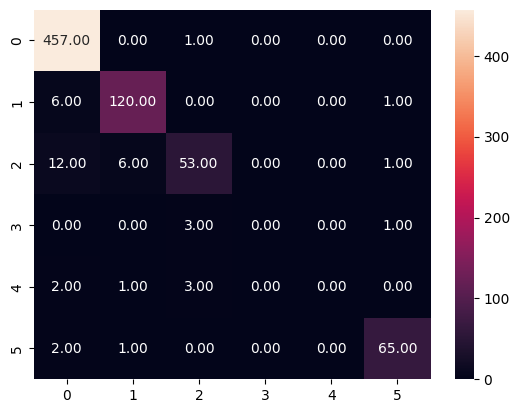

In [12]:
trainer.run()

In [13]:
dp.classes

['English', 'Germans', 'French', 'Spaniards', 'Tuscans', 'Belgium']

In [7]:
len(nc.valid_nodes)

123

In [8]:
len(nc.array_of_graphs_for_validation)

119

In [39]:
cr.node_classes_sorted

,node,class_id
0,0,0
23,1,0
45,2,0
61,3,0
74,4,0
...,...,...
14467,3762,1
14492,3763,2
16500,3764,1
21116,3765,2


In [48]:
from sklearn.metrics import f1_score

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
f1_score(y_true, y_pred, average='weighted', labels=[0])

0.8

In [1]:
type([])

list

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6



# tmp

In [20]:
import networkx as nx

In [21]:
G = nx.Graph()
G.add_edge(0, 1, pop_index_1='a', pop_index_2='b', weigth=1)
G.add_edge(0, 2, pop_index_1='a', pop_index_2='c', weigth=2)
G.add_edge(0, 3, pop_index_1='a', pop_index_2='d', weigth=3)
nx.write_edgelist(G, 'tmp.csv', data=['pop_index_1', 'pop_index_2', 'weigth'])

In [23]:
G.nodes

NodeView((0, 1, 2, 3))

In [22]:
pd.read_csv('tmp.csv', header=None, sep=' ')

,0,1,2,3,4
0,0,1,a,b,1
1,0,2,a,c,2
2,0,3,a,d,3
